The presented notebook is a tool designed for analyzing and classifying B-cell lymphomas, specifically those belonging to the DLBCL. 

**Data preparation:**

1. A reference cohort along with its annotation file. A PCA analysis plot of the reference cohort is shown to confirm that there are no batch effects present in the data.
2. A sample gene expression matrix where the required type of data is RNA-Seq 
3. Gene signature file located in the Datasets folder.

**Quality check:**

Next, the sample gene expression matrix is log2 transformed. A quality check (QC) is performed to ensure that the data is suitable for analysis and free from any issues that may impact the accuracy of the downstream analysis.

**Classification:**

Creation of KNN model based on the reference cohort. Calculation of ssGSEA scores with sample gene expression and gene signatures. Classification is performed by sample ssGSEA scores and KNN model based on the reference cohort.

# Import of Python base packages

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False
import matplotlib.pyplot as plt
import copy
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
from pathlib import Path

In [3]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('white')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from lme.utils import *
from lme.plotting import *
from lme.classification import *
from lme.pathway_scoring import *

Constants

In [6]:
REFERENCE_COHORT_ANNOTATION = 'datasets/pan_cohort_annotation.tsv'
REFERENCE_COHORT_EXPRESSION = 'datasets/pan_cohort_signatures.tsv.gz'
GENE_SIGNATURES = 'databases/signatures.gmt'

To run all of the analyses for your data change the SAMPLE_EXPRESSION and SAMPLE_ANNOTATION values correspondingly to your gene expression and expression annotation file paths and on the left corner of the notebook chose the run section and click the run all cells button.




Insert the path to your expression matrix and its annotation in corresponding variables:

SAMPLE_EXPRESSION

SAMPLE_ANNOTATION


In [7]:
SAMPLE_EXPRESSION = 'datasets/GSE56313/expressions.tsv.gz'
SAMPLE_ANNOTATION = 'datasets/GSE56313/annotation.tsv'

## Set Palette

Color palette for DLBCL GCB and ABC subtypes.

In [8]:
dlbcl_subtype_p = {'ABC': '#A630B5', 'GCB': '#E7A949', 'UNC': '#AAAAAA'}

Color pallete of colors for different lymphoma types: Burrkits Lymphoma, Follicular Lymphoma, Diffuse large B-cell lymphoma.

In [9]:
diagnosis_p = {'Burkitt_Lymphoma': '#BB3556',
         'Diffuse_Large_B_Cell_Lymphoma': '#AAAAAA',
         'Follicular_Lymphoma': '#44D8D1'}

Shorten names for each lymphoma type mentioned above.

In [10]:
diagnosis_shortener = {'Diffuse_Large_B_Cell_Lymphoma': 'DLBCL', 'Follicular_Lymphoma': 'FL',
               'Burkitt_Lymphoma': 'BL'}

In [11]:
diagnosis_rn_p = {'BL': '#BB3556',
         'DLBCL': '#AAAAAA',
         'FL': '#44D8D1'}

Color pallete for high and low values.

In [12]:
high_low_p = {'High': '#E04000', 
              'Low': '#90C0F0'}
high_low_o = ['High', 'Low']
high_low_map = {True:'High',
                False: 'Low'}

Color pallete for DHIT sig positive and negative conditions.

In [13]:
dhit_p = {'DHITsig-neg': dlbcl_subtype_p['GCB'], 'DHITsig-pos': '#b40426', 'ABC': dlbcl_subtype_p['ABC']}

Generate color palette for LME subtypes.

In [14]:
lme_o = ['LME-GC', 'LME-ME', 'LME-IN', 'LME-DE', ]
lme_p = {
            'LME-GC': '#2980B9',
            'LME-ME': '#9B59B6', 
            'LME-IN': '#1ABC9C', 
            'LME-DE': '#E74C3C',}

Create a list of the signaling pathway signatures.

In [15]:
progeny_selected = ['NFkB', 'p53', 'PI3K']
len(progeny_selected)

3

Create a list of selected/needed signatures for further calssification.

In [16]:
signatures_selected = [
 'Lymphatic_endothelium',
 'Angiogenesis',
 'CAF',
 'Fibroblastic_reticular_cells',
 'Matrix',
 'Matrix_remodeling',
 'Granulocyte_traffic',
 'Protumor_cytokines',
 'Follicular_dendritic_cells',
 'Macrophages',
 'M1_signature',
 'T_cell_traffic',
 'MHCII',
 'MHCI',
 'Follicular_B_helper_T_cells',
 'Treg',
 'T_cells',
 'Checkpoint_inhibition',
 'NK_cells',
 'B_cells_traffic',
 'B_cells',
 'Proliferation_rate']
len(signatures_selected)

22

# Data preparation 

## Load the reference cohort

Read reference cohort gene expressions

In [17]:
cohort_signatures_scaled = read_dataset(REFERENCE_COHORT_EXPRESSION).T
cohort_signatures_scaled.shape

(5116, 38)

In [18]:
cohort_signatures_scaled.head()

,EGFR,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,...,B_cells_traffic,Follicular_B_helper_T_cells,Th1_signature,T_cells,Checkpoint_inhibition,MHCII,MHCI,NK_cells,B_cells,Proliferation_rate
DLC0001,-1.100459,1.778296,-0.010550,0.370199,1.009720,-0.995537,0.312762,1.193305,0.933070,-1.007430,...,1.901869,4.907127,2.858243,1.984391,1.646320,0.214866,-0.519421,0.392673,0.138287,-2.709766
DLC0002,1.515182,2.768054,0.654394,2.370840,0.975191,-0.899303,1.767230,1.801683,1.415524,-1.277588,...,0.273988,-0.073384,-0.736010,0.176268,0.479735,-0.543240,-1.204911,0.021682,0.883285,0.618806
DLC0003,-0.855085,0.215444,2.023212,0.471082,1.987488,0.090416,-0.489591,0.438043,1.810002,-1.136433,...,-0.014866,1.135015,1.718405,2.099066,1.630966,0.098000,-1.170603,2.067505,-2.015865,-0.399773
DLC0004,1.170281,2.552209,1.924494,2.637014,1.168497,-2.202614,3.159769,1.717606,2.066829,-1.815582,...,-1.195651,0.289175,-0.450115,1.134542,-0.586538,0.067294,-0.608622,2.168512,-0.309114,-2.152889
DLC0005,-0.414280,0.536973,2.633446,0.993703,0.666727,-1.963422,1.470179,0.737218,2.252673,-1.626322,...,0.895766,3.279645,1.519968,1.882563,1.718104,0.507834,-0.551072,0.550601,0.164978,-1.908548


Read reference cohort annotation file

In [19]:
cohort_ann = read_dataset(REFERENCE_COHORT_ANNOTATION)
cohort_ann.shape

(5116, 32)

In [20]:
cohort_ann.head()

,Cohort,Cohort_group,SORTN,COO_BG,COO_original,LME,DHITsig_predicted,DHITsig_original,Diagnosis,GenClass7,...,DLBCL90-Group,COO_RT,COO_Hans,Transformed_FL,series_ids,geo_accessions,dbGAP_id,ID1,ID2,platform_id
Sample,,,,,,,,,,,,,,,,,,,,,
GSM3302930,GSE117556,GSE117556,1,ABC,ABC,LME-ME,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302930,NaN,RMDB_1,NaN,GPL14951
GSM3302931,GSE117556,GSE117556,2,GCB,GCB,LME-GC,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302931,NaN,RMDB_2,NaN,GPL14951
GSM3302932,GSE117556,GSE117556,3,GCB,GCB,LME-GC,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302932,NaN,RMDB_3,NaN,GPL14951
GSM3302933,GSE117556,GSE117556,4,ABC,ABC,LME-DE,DHITsig-neg,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302933,NaN,RMDB_4,NaN,GPL14951
GSM3302934,GSE117556,GSE117556,5,GCB,GCB,LME-ME,DHITsig-pos,NaN,Diffuse_Large_B_Cell_Lymphoma,NaN,...,NaN,NaN,NaN,NaN,GSE117556,GSM3302934,NaN,RMDB_5,NaN,GPL14951


In [21]:
len(cohort_signatures_scaled.index & cohort_ann.index)

5116

## Confirm that reference cohort does not have any problems

On the figure below you can see PCA analyses of Reference Cohort grouped by datasets. There are no batches in the pca_plot which indicates that the data has no problems.

![PCA of Reference](plots/pca_of_reference.svg)

Here on the second figure below is presented the LME subtypes of each sample. Here also you can see that there are no batch effects in the reference cohort. Combining this two results we can be sure that the reference cohort data doesn't have any problems and can be used in the further analysis. 

![Referene pca grouped by LME](plots/pca_of_reference_grouped_by_LME.png)

## Load gene signatures

Load gene signatures from the gene_signatures.gmt file

In [22]:
signatures = read_gene_sets(GENE_SIGNATURES)

# Preparation and QC of gene expression matrix

## Read example data gene expression

In [23]:
expression_matrix_ann = read_dataset(SAMPLE_ANNOTATION)
expression_matrix_ann.shape

(55, 12)

In [24]:
expression_matrix_ann.head()

,Patient,Cohort,Cohort_group,Diagnosis,BAGS_class,CD79B_Status,EZH2_Status,MYD88_Status,COO,COO_BG,DHITsig,platform_id
Sample,,,,,,,,,,,,
GSM1358939,H1,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,ABC,GCB,DHITsig-neg,GPL570
GSM1358940,H10,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Unclassified,NaN,WT,NaN,ABC,ABC,DHITsig-neg,GPL570
GSM1358941,H11,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,NaN,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358942,H12,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centrocyte,WT,WT,WT,GCB,GCB,DHITsig-neg,GPL570
GSM1358943,H13,GSE56313,GSE56313,Diffuse_Large_B_Cell_Lymphoma,Centroblast,WT,WT,WT,ABC,ABC,DHITsig-neg,GPL570


If your data is log2 transformed (mean expressions should be between 0 and 18) than you can proceed to QC section.
If it is not log2 transforemd than run the code snippet provided below and procedd to QC section.

In [25]:
expression_matrix = np.log2(1+read_dataset(SAMPLE_EXPRESSION).T)

In [26]:
expression_matrix.head()

Gene_symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZYX,ZZEF1,ZZZ3,abParts,av27s1,hADV36S1,hsa-let-7a-3,hsa-let-7b,hsa-mir-4763,mir-223
GSM1358939,3.398629,3.229542,2.242460,8.975672,2.932449,2.340419,2.625855,4.157479,2.242557,2.410004,...,7.919923,7.535532,9.066579,4.544640,2.242722,2.411134,2.24246,2.24246,2.24246,4.002745
GSM1358940,2.242460,3.358790,2.242460,10.830553,3.451486,2.251113,2.242460,3.012059,2.242557,2.242460,...,8.337970,7.966719,9.343023,5.076570,2.242722,2.245702,2.24246,2.24246,2.24246,4.787586
GSM1358941,2.390763,3.895996,2.762986,9.225935,2.453358,2.242460,2.242460,3.308393,2.242557,2.517436,...,10.429838,8.965752,8.243231,4.823728,2.259413,2.587467,2.24246,2.24246,2.24246,4.002745
GSM1358942,2.390763,2.753845,2.242460,10.882917,2.980621,2.251113,2.242460,3.130747,2.242557,2.242460,...,8.937943,8.583962,8.718742,8.438893,2.242722,2.245702,2.24246,2.24246,2.24246,7.509161
GSM1358943,2.405299,3.218549,2.246557,9.335253,2.434799,2.435370,2.242460,3.539215,2.242557,2.242460,...,9.278991,7.003909,8.552902,5.163131,2.540013,3.346210,2.24246,2.24246,2.24246,5.609699


## Quality check for the example data

The Quality Check (QC) section identifies batches, outliers, and assesses the expression data distribution and after each check it saves the generated plot in the Plots folder for your further use.

We will provide examples of both bad and good datasets, which will help you differentiate them visually and understand the types of possible data quality issues that may affect downstream analyses.

Creating a Plots direcotry to save all of the generated plots.

In [27]:
os.mkdir('Plots')

### Batch effect detection

This section is responsible for identifying any potential batch effects in the analyzed data using UMAP and PCA analyses. The results of these analyses are plotted to visualize any potential batches in the data.

If you are not familiar with batch effects follow [this link](https://towardsdatascience.com/batcheffectsc71c886ca9c5)

Below is an example of a sample check results for the presence of batch effects using the UMAP analysis. Two plots have been generated to visualize possible analysis results. The plot on the right shows an example of a dataset with no identified issues, whereas the plot on the left exhibits potential batch effects.

You can see that the plot on the right shows two distinct clusters of data points that are grouped quite far from each other. This is indicative of the presence of a potential batch effect.

If your data plot resembles the one on the right, remove any identified batch effects to ensure accurate and reliable results.

[Here are the instructions for batch effect removal](https://github.com/chichaumiau/removeBatcheffect)

![Umap plot example](plots/umap_example.svg)

Generate umap_plot for our input data


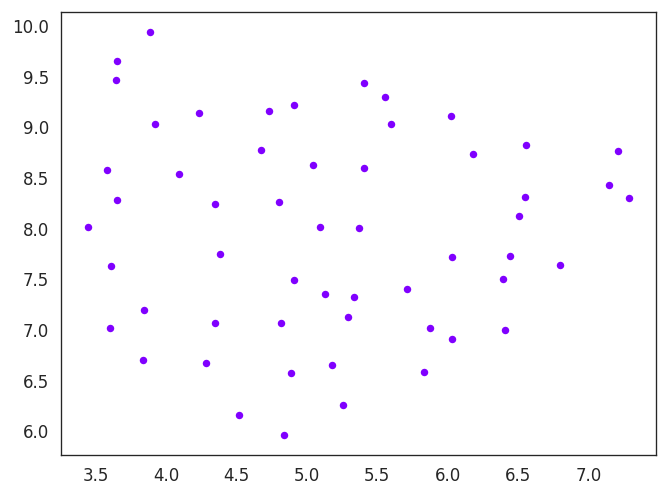

In [28]:
# Generate umap_plot for the input data
fig_umap, axes_umap = plt.subplots()

umap_plot(expression_matrix, legend = 'Out',ax = axes_umap)

# Saving the generated umap plot into a picture.
fig_umap.savefig('Plots/umap_batches.svg')

### Batch detection by PCA

To further enhance the significance of our analysis, we plot PCA of our data to ensure that it is free from any batch effects.

An illustrative example is provided below, where it is clear that the presence of batches is reflected in the plot on the left as two distinct groups of data points that are far from each other. In contrast, a normal dataset appears as a single group of data points that are relatively close to each other, as reflected in the PCA plot.

This step is essential to ensure that our data is free from any systematic variation that could confound our analyses, and to ensure that any observed effects are biologically meaningful.

![PCA plot of examples](plots/pca_batches_example_colored.svg)

Generate the pca plot for the annotated_expressions.

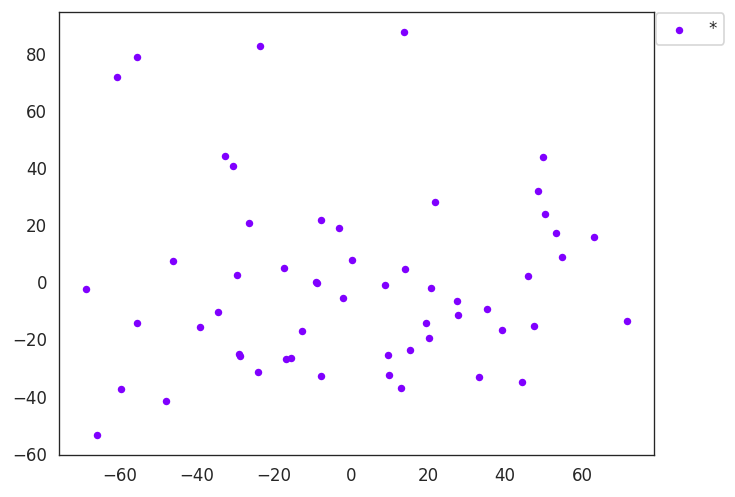

In [53]:
# Generate the pca plot for the annotated_expressions

fig_pca_batches, ax_pca_batches = plt.subplots()

pca_plot(expression_matrix, legend = 'out',ax = ax_pca_batches)

# Saving the generated pca plot into a picture.
fig_pca_batches.savefig('Plots/pca_batches.svg')

### Outlier detection

The purpose of this section is to identify outliers in the annotated_expression data through PCA plots.

Below is an illustrative example of data outliers.
In the plot on the left, two points lie far away from the main group of data points, indicating the presence of outliers in the dataset. In contrast, the data points in the plot on the right lie relatively close to each other, with no outliers detected.

To get detailed information on data outliers, follow this [link](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

![Pca plot with data that has/does not have outliers](plots/pca_outliers_example.svg)

The code cell below generates a PCA plot of the annotated_expression data where sample IDs are located in the row positions, which facilitates dimension reduction based on samples. This plot can help identify any possible data outliers.

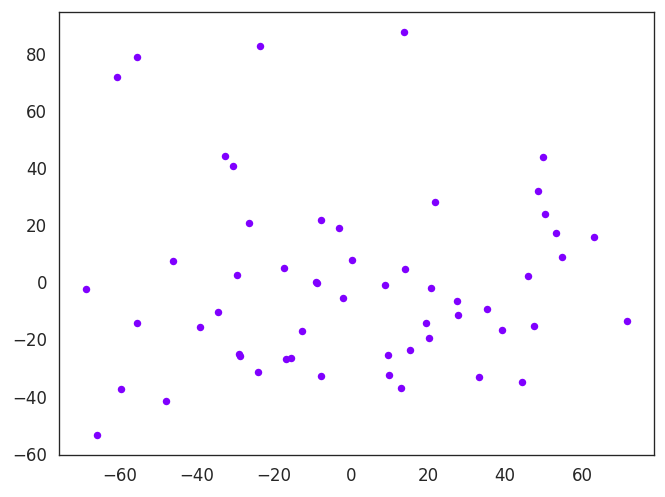

In [54]:
# Generate pca plot for annotated_expression to find outliers

fig_pca_outliers,ax_pca_outliers = plt.subplots()

pca_plot(expression_matrix, legend= None, ax= ax_pca_outliers)

# Saving the generated pca plot into a picture.
fig.savefig('Plots/pca_outliers.svg')

If the pca_plot of your data suggests the analyzed data contain outliers, remove the outlying points from your dataset.

### Data distribution check

Data distribution check

This is the final section of the QC, where data quality is checked based on its distribution.

As with the previous sections, an example of two gene expression datasets is provided below, with one exhibiting a good-quality dataset and the other exhibiting a poor-quality dataset, as indicated by their respective distribution plots.

In the plot on the right, the expression values start off very low and then rise before dropping down. This pattern suggests potential RNA degradation, which can compromise the reliability and accuracy of downstream analyses. In contrast, the distribution plot on the left shows good-quality gene expression data.
Deviations from such distributions may indicate gene degradation, should be carefully investigated and, if necessary, corrected to ensure high-quality data.

If your data plot shows distribution of a good quality data, you can proceed with the analyses. If it resembles the one on the right, then your data is probably abnormal and might have RNA degradation. In the case of RNA degradation,  do not proceed with the analyses and choose a new dataset.

![Data distribution example](plots/distplot_example.svg)

The code snippet provided generates a visualization of the distribution of annotated expression values. This type of data visualization is useful for identifying trends and patterns in gene expression data and can aid in the quality control and preprocessing of the data.

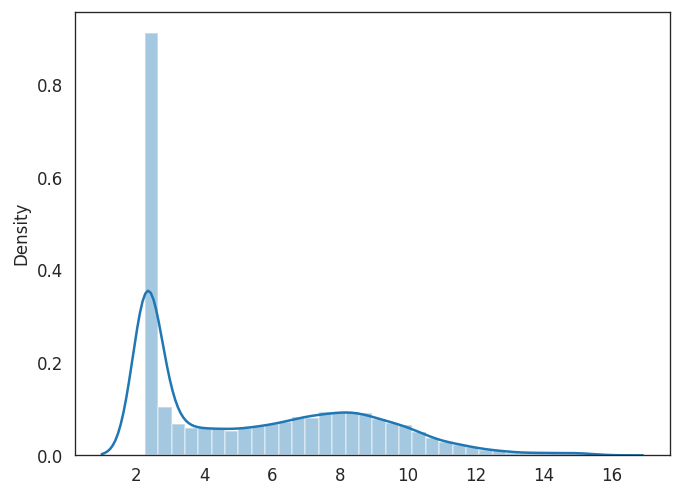

In [56]:
# Generating distribution plot

fig_dist, ax_dist = plt.subplots()

sns.distplot(expression_matrix.mean(), kde = True)

# Saving the generated distribution plot into a picture.
fig_dist.savefig('Plots/distribution.svg')

If you have successfully passed all of the QC tests, you can move to the next step. If there are any data issues, fix them before proceeding to the next step as they can affect the results of the analyses.

# Classification of SAMPLE_EXPRESSION

1. Create a KNeighborsClusterClassifier model and learn it to predict LME subtypes based on TCGA reference cohort
2. Load gene signatures from gmt file.
3. Calculate signature ssGSEA scores and PROGENy scores. We use our own ssGSEA formula. The ssGSEA scores matrix should have the samples as rows and signatures in columns.
4. Perform median scaling on the ssGSEA scores. Median scaling helps to:
   * Have all of the data in one interval to compare them easily
   * Remove the effect of extreme values on prediction
   * Have biased model performance
5. Pass the ssGSEA scores to the KNN model to predict the LME-subtype for each sample.

## Create a KNN model based on reference cohort

In [32]:
cohort_ann_filtered = cohort_ann[(cohort_ann.Diagnosis=='Diffuse_Large_B_Cell_Lymphoma') & 
                                 (~cohort_ann.LME.isna())]
cohort_ann_filtered.shape

(4656, 32)

In [33]:
LME_MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=3, k=35).fit(
    *to_common_samples([cohort_signatures_scaled[signatures_selected + progeny_selected], cohort_ann_filtered.LME]))

In [34]:
LME_MODEL

## Calculate ssGSEA and PROGENy scores of signatures

Calculate ssgsea and progeny scores. 
Concatenate both results to each other.

In [35]:
x = ssgsea_formula(expression_matrix, signatures)
len(signatures)

27

In [36]:
ssgsea_scores = ssgsea_formula(expression_matrix, signatures)
progeny_scores = run_progeny(expression_matrix)

In [37]:
signatures_calculated = pd.concat([ssgsea_scores, progeny_scores], axis=1)
signatures_calculated.shape

(55, 41)

In [38]:
signatures_calculated.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-160.876254,896.872755,3919.711386,3689.651433,5876.870836,5117.140715,-2061.804719,3645.144760,3993.136722,1754.957862,...,6079.960648,1095.099634,5896.664394,-2819.694663,1646.742262,5841.041201,121.156252,-351.990797,386.750766,3335.329043
GSM1358940,2185.034275,2575.990926,4826.591712,5182.149349,6670.413278,6930.909019,-301.631037,4075.105078,6624.723233,1939.012559,...,6579.714463,1069.881426,6011.486202,-2802.103041,1821.945534,6000.588490,114.289349,-362.913911,395.411393,3228.722225
GSM1358941,-440.063110,1277.589174,4691.090399,4818.726509,6714.593309,7485.075341,-2614.745564,3601.739387,5935.233492,114.513259,...,5488.651978,1279.928709,5633.632101,-2693.907177,1824.552162,5646.854135,96.903704,-324.242911,374.021116,3328.312248
GSM1358942,631.707180,1861.778047,6457.318986,5706.337687,7626.186603,8535.359424,-1466.839608,3701.799906,3746.375372,2354.974009,...,5765.952875,1236.627929,5777.963537,-2744.846346,2085.213090,5884.520618,66.714042,-435.153794,392.913515,3299.599816
GSM1358943,1217.914505,1565.561173,3574.439413,3625.067635,5339.923651,6208.988263,-1880.800201,3230.314962,6074.992741,313.402573,...,5829.559431,1096.409014,5416.434101,-2784.548138,1694.701682,5533.012806,89.985699,-298.601421,392.335983,3138.276436


Generate distribution plot for the signatures.

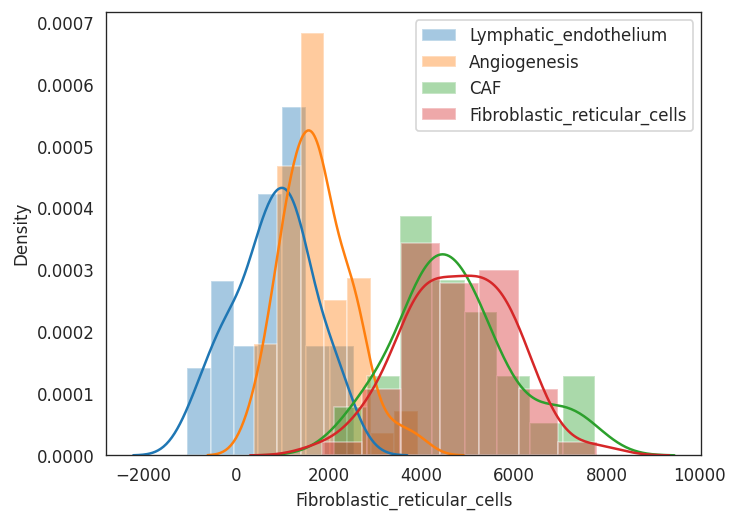

In [39]:
_, ax = plt.subplots(1, 1)
for i in signatures_calculated.columns[:4]:
    sns.distplot(signatures_calculated[i], label=i, ax=ax, kde=True)
ax.legend()

Scale signatures to improve accuracy and to faciliate visualisation.

In [40]:
signatures_scaled = median_scale(signatures_calculated, 3)
signatures_scaled.shape

(55, 41)

In [41]:
signatures_scaled.head()

,Lymphatic_endothelium,Angiogenesis,CAF,Fibroblastic_reticular_cells,Matrix,Matrix_remodeling,Granulocyte_traffic,Protumor_cytokines,Follicular_dendritic_cells,Macrophages,...,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
GSM1358939,-1.436759,-1.344182,-0.747056,-1.252811,-0.827535,-1.515633,-0.178132,-0.583759,-1.941545,-0.344663,...,-1.159207,-1.039683,-0.225652,-0.463819,-1.096586,-0.261157,0.284551,0.067274,-1.032242,0.591873
GSM1358940,1.972933,1.578868,0.182446,0.337655,-0.049585,0.202221,1.554106,0.008779,0.264053,-0.183658,...,0.000000,-1.545051,0.083240,-0.191182,0.212244,0.211701,-0.116696,-0.211603,-0.332650,-0.567286
GSM1358941,-1.842546,-0.681422,0.043564,-0.049623,-0.006273,0.727082,-0.722297,-0.643577,-0.313825,-1.779664,...,-2.530780,2.664249,-0.933257,1.485650,0.231716,-0.836680,-1.132575,0.775703,-2.060522,0.515578
GSM1358942,-0.284769,0.335549,1.853851,0.896251,0.887409,1.721826,0.407390,-0.505681,-2.148362,0.180210,...,-1.887565,1.796511,-0.544979,0.696189,2.178944,-0.132295,-2.896619,-2.055953,-0.534425,0.203381
GSM1358943,0.567261,-0.180113,-1.100941,-1.321634,-1.353932,-0.481524,0.000000,-1.155446,-0.196689,-1.605683,...,-1.740026,-1.013444,-1.517560,0.080886,-0.738312,-1.174078,-1.536808,1.430353,-0.581077,-1.550723


Generate distribution plots for already scaled signature values.

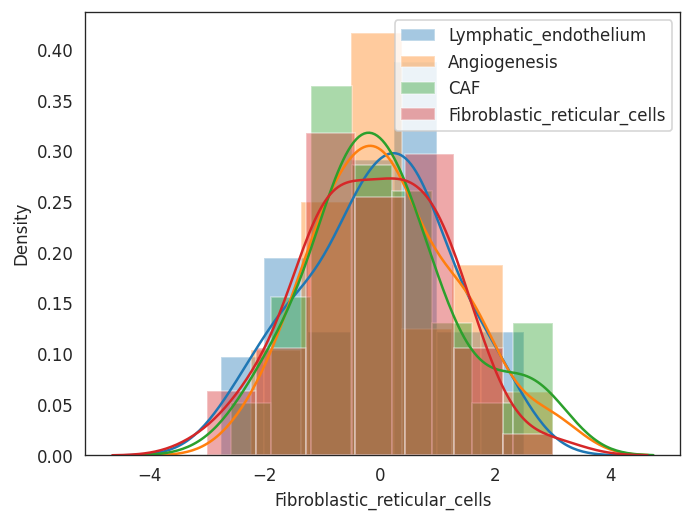

In [59]:
# generating distribution plots for already scaled signature values

fig, ax = plt.subplots(1, 1)
for i in signatures_scaled.columns[:4]:
    sns.distplot(signatures_scaled[i], label=i, ax=ax, kde=True)
ax.legend()

# Saving the generated distribution plots into a picture.
fig.savefig('Plots/scaled_data_distribution.svg')

Below are provided several boxplots to make it easier to understand the corresponding signature scores for each subtype.
In this two examples we chose the Follicluar dendritic cells and proliferation rate but you can change them to the signatures that you are interseted in to analyze.

In [68]:
signature = signatures_scaled.Follicular_dendritic_cells

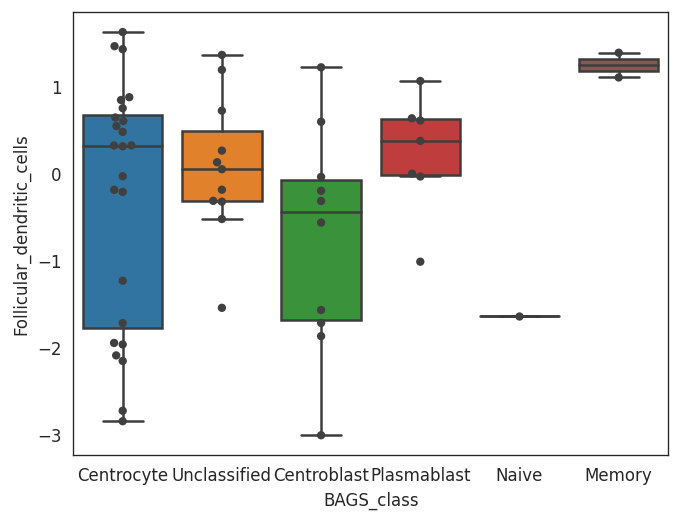

In [69]:
fig_signature_boxplot, ax_signature_boxplot = plt.subplots()

sns.boxplot(y=signature, x=expression_matrix_ann.BAGS_class, fliersize=0, ax= ax_signature_boxplot)
sns.swarmplot(y=signature, x=expression_matrix_ann.BAGS_class, s=5, color='.25', ax= ax_signature_boxplot)

# Save the generated boxplot into a picture
fig_signature_boxplot.savefig('Plots/Follicular_dendritic_cells_boxplot.svg')

In [ ]:
fig_signature_boxplot, ax_signature_boxplot = plt.subplots()

signature = signatures_scaled.Proliferation_rate
sns.boxplot(y=signature, x=expression_matrix_ann.BAGS_class, fliersize=0, ax= ax_signature_boxplot)
sns.swarmplot(y=signature, x=expression_matrix_ann.BAGS_class, s=5, color='.25', ax= ax_signature_boxplot)

# Save the generated boxplot into a picture
fig_signature_boxplot.savefig('Plots/proliferation_boxplot.svg')

## Classify the samples

In [46]:
lme_predicted = LME_MODEL.predict(signatures_scaled[LME_MODEL.X.columns]).rename('LME')

In [47]:
type(lme_predicted)

pandas.core.series.Series

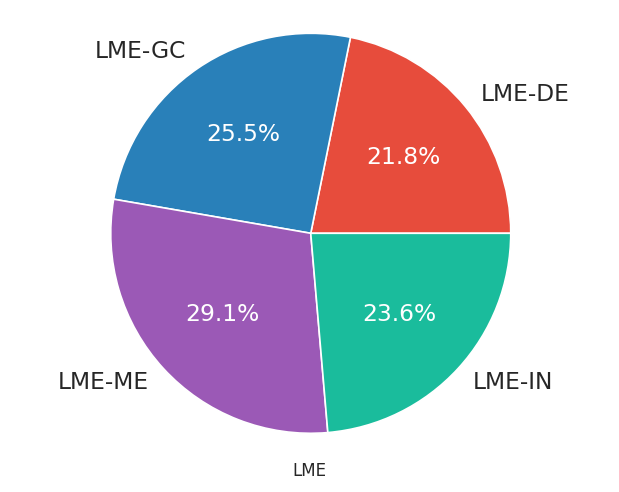

In [60]:
tme_palette = {"IE": '#0000CC', "IE/F": '#009999', "F": '#CC0033', "D": '#FF9900'}

fig_pie_plot, ax_pie_plot = plt.subplots()

vector_pie_plot(lme_predicted,palette=lme_p, ax= ax_pie_plot)

# Saving the generated pie plot into a picture.
fig_pie_plot.savefig('Plots/classified_samples_percentage.svg')

Here you can see the COO subtypes of DLBCL for each LME subtype sample

In [49]:
pd.crosstab(expression_matrix_ann.COO_BG, lme_predicted)[lme_o]

LME,LME-GC,LME-ME,LME-IN,LME-DE
COO_BG,,,,
ABC,6,4,7,6
GCB,8,12,6,6


In [50]:
so = list(pd.concat([expression_matrix_ann.COO_BG[expression_matrix_ann.COO_BG==i] for i in ['GCB', 'ABC']]).index)
so = list(pd.concat([lme_predicted.loc[so][lme_predicted.loc[so]==i] for i in lme_o]).index)
len(so)

55

Below is the last part of the whole analysis  where you are provided with the gene signatures heatmap with the corresponding LME subtypes which is also divided into 2 subtypes of COO DLBCL.

To make it easier to see meaning of each color in the heatmap below you can see the color pallete for each type of the lymphoma

<AxesSubplot:>

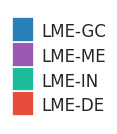

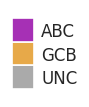

In [51]:
patch_plot(lme_p, order=lme_o)
patch_plot(dlbcl_subtype_p)

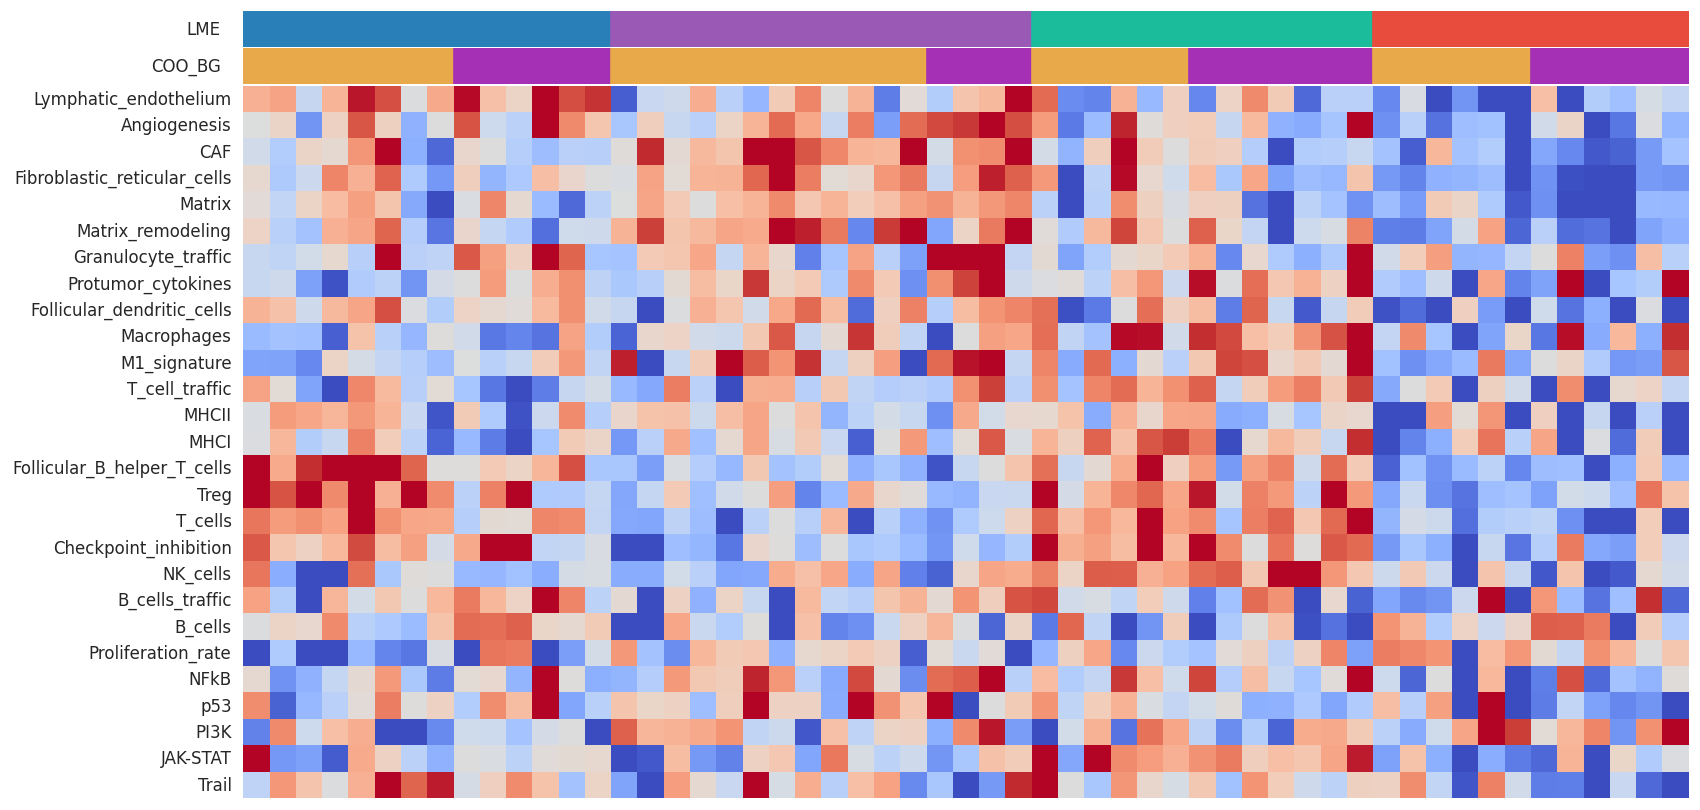

In [62]:
af = axis_matras([.3, .3, 6], x_len=14)

ax = next(af)
line_palette_annotation_plot(lme_predicted[so], ax=ax, palette=lme_p)

ax = next(af)
line_palette_annotation_plot(expression_matrix_ann.COO_BG[so], ax=ax, palette=dlbcl_subtype_p)

ax = next(af)
sns.heatmap(signatures_scaled.loc[so, signatures_selected + progeny_selected + ['JAK-STAT', 'Trail']].clip(-2, 2).T,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm, ax=ax)
plt.tight_layout(pad=.1)

# Saving the generated heatmap plot into a picture.
ax.figure.savefig('Plots/signatures_heatmap.svg')